In [1]:
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from hiive.mdptoolbox.example import forest
from hiive.mdptoolbox import mdp
from hiive.mdptoolbox import util
import gym
import numpy as np
import sys
import os
from numpy.random import choice
import pandas as pd
import seaborn as sns
np.random.seed(44)

In [2]:
def test_policy(P, R, policy, test_count=1000, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / total_episode

In [3]:
def grid_search_VI(P, R, discount=0.9, epsilon=[1e-9]):
    vi_df = pd.DataFrame(columns=["Epsilon", "Policy", "Iteration",
                                  "Time", "Reward", "Value Function"])
    for eps in epsilon:
        vi = ValueIteration(P, R, gamma=discount, epsilon=eps, max_iter=int(1e15))
        vi.run()
        reward = test_policy(P, R, vi.policy)
        info = [float(eps), vi.policy, vi.iter, vi.time, reward, vi.V]
        df_length = len(vi_df)
        vi_df.loc[df_length] = info
    return vi_df

Value Iteration

In [7]:
P,R = forest(20, r1 = 10, r2 = 4, p = 0.1)

In [ ]:
fm_20_vi = grid_search_VI(P, R, discount = 0.9, epsilon = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9])

In [ ]:
fm_20_vi

In [ ]:
fm_20_vi.Policy.nunique()

In [ ]:
fm_20_vi.Policy.unique()

Policy Iteration

In [ ]:
pi = PolicyIteration(P, R, gamma=0.9, max_iter=1e6)
pi.run()
pi_pol = pi.policy
pi_reward = test_policy(P, R, pi_pol)
pi_iter = pi.iter
pi_time = pi.time
pi_iter, pi_time, pi_reward

Q-Learning

In [8]:
def grid_search_Q(P, R, discount=0.9, alpha_dec=[.99], alpha_min=[0.001],
            epsilon=[1.0], epsilon_decay=[0.99], n_iter=[1000000]):
    q_df = pd.DataFrame(columns=["Iterations", "Alpha Decay", "Alpha Min",
                                 "Epsilon", "Epsilon Decay", "Reward",
                                 "Time", "Policy", "Value Function",
                                 "Training Rewards","Training Errors"])

    count = 0
    for i in n_iter:
        for eps in epsilon:
            for eps_dec in epsilon_decay:
                for a_dec in alpha_dec:
                    for a_min in alpha_min:
                        q = QLearning(P, R, discount, alpha_decay=a_dec,
                                      alpha_min=a_min, epsilon=eps,
                                      epsilon_decay=eps_dec, n_iter=i)
                        q.run()
                        reward = test_policy(P, R, q.policy)
                        count += 1
                        print("{}: {}".format(count, reward))
                        st = q.run_stats
                        rews = [s['Reward'] for s in st]
                        error = [s['Error'] for s in st]
                        info = [i, a_dec, a_min, eps, eps_dec, reward,
                                q.time, q.policy, q.V, rews, error]

                        df_length = len\
                            (q_df)
                        q_df.loc[df_length] = info
    return q_df

In [9]:
epsilons = [0.5, 0.8, 0.9, 0.99]
epsilon_decays = [.999]
alpha_decs = [0.999]
alpha_mins =[0.001]
iters = [int(e) for e  in [1e5, 1e6, 1e7]]
q_df = grid_search_Q(P, R, discount=0.9, alpha_dec=alpha_decs, alpha_min=alpha_mins,
            epsilon=epsilons, epsilon_decay=epsilon_decays, n_iter=iters)

1: 0.65
2: 0.7
3: 3.336999250454933
4: 0.75
5: 3.0969654004868574
6: 0.95
7: 0.85
8: 3.375967647528069
9: 3.375427378265126
10: 3.1405023692989897
11: 3.3685111096420144
12: 3.0180004217071827


In [16]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [28]:
q_df

,Iterations,Alpha Decay,Alpha Min,Epsilon,Epsilon Decay,Reward,Time,Policy,Value Function,Training Rewards,Training Errors
0,100000,0.999,0.001,0.50,0.999,0.650000,4.291963,"(0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ...","(4.471038011454873, 5.025660735025568, 4.92130...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0007963396111227978, 0.007928051922376054, ..."
1,100000,0.999,0.001,0.80,0.999,0.700000,4.195918,"(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...","(4.473771270693758, 5.029373245640063, 4.91404...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0007907819291327406, 0.0, 0.019589992654057..."
2,100000,0.999,0.001,0.90,0.999,3.336999,3.616230,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, ...","(4.469918561152517, 5.023971946068373, 4.88757...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.09811700348643991, 0.09720613035144891..."
3,100000,0.999,0.001,0.99,0.999,0.750000,3.625663,"(0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, ...","(4.480269585574111, 5.024570180897871, 4.88333...","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[0.0998991348840991, 0.013060121512035233, 0.0..."
4,1000000,0.999,0.001,0.50,0.999,3.096965,35.210840,"(0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","(4.475855325043823, 5.030226174092417, 5.02998...","[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.15451192513755377, 0.2236816222815877, 0.01..."
5,1000000,0.999,0.001,0.80,0.999,0.950000,41.947655,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","(4.471055284159403, 5.026254779885659, 5.02538...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.032464005474106696, 0.0, 0.0, 0.21657861081..."
6,1000000,0.999,0.001,0.90,0.999,0.850000,60.805779,"(0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, ...","(4.478223573669712, 5.03171902799988, 5.030504...","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[0.13728698671336292, 0.0, 0.04081871957052836..."
7,1000000,0.999,0.001,0.99,0.999,3.375968,71.039938,"(0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","(4.467146807644017, 5.018867684616455, 5.02587...","[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[0.10337947461048863, 0.0, 0.14320119771385495..."
8,10000000,0.999,0.001,0.50,0.999,3.375427,491.203797,"(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","(4.471608812427809, 5.022628506498404, 5.02575...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 1.0, ...","[0.014399954853971837, 0.0, 0.0002827437422134..."
9,10000000,0.999,0.001,0.80,0.999,3.140502,366.564367,"(0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","(4.476619137723397, 5.027586855505139, 5.03113...","[1.0, 1.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...","[0.16310183388575908, 0.06003895869547831, 0.0..."


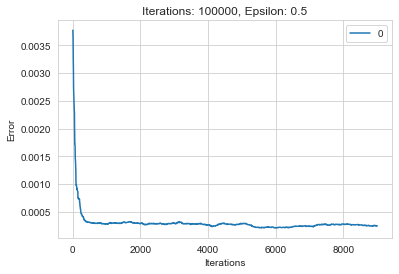

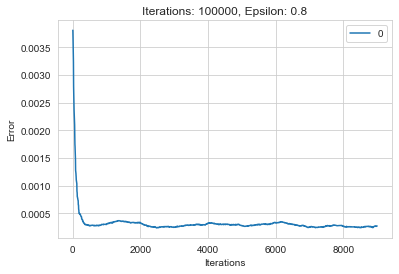

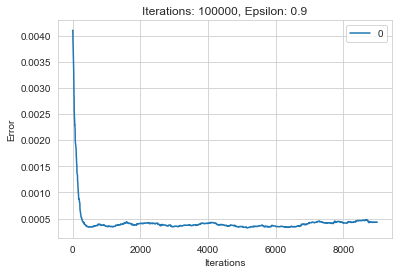

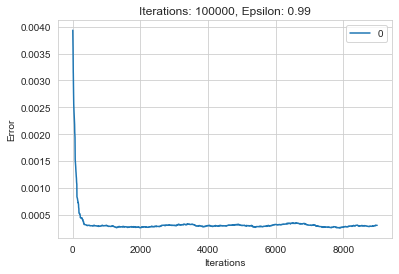

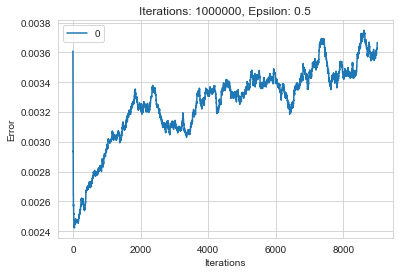

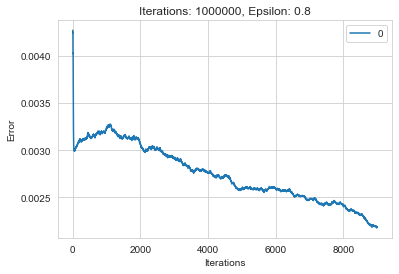

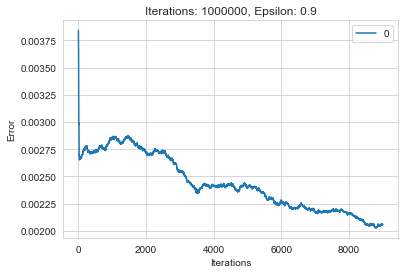

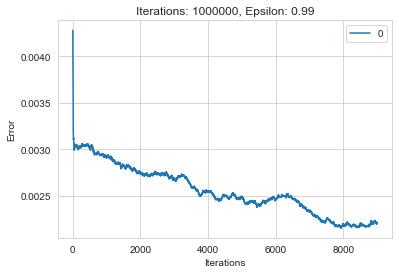

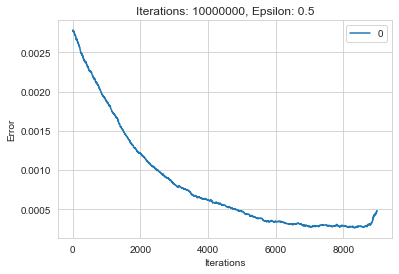

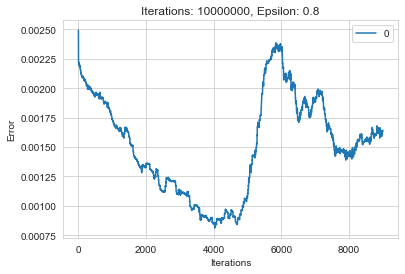

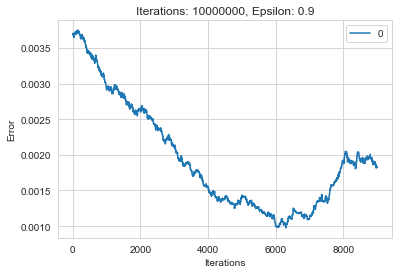

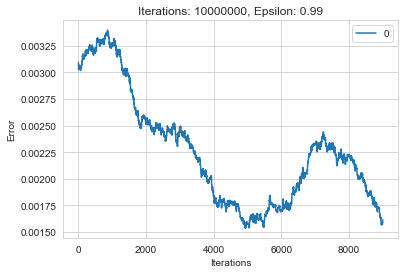

In [42]:
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
for i in range(12):
    pd.DataFrame(running_mean(q_df['Training Errors'][i],1000)).plot()
    plt.title('Iterations: {}, Epsilon: {}'.format(q_df['Iterations'][i], q_df['Epsilon'][i]))
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.show()
    plt.close()